# General Run Template

In [33]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [34]:
import os
import pickle
from datetime import datetime
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from deep_dss.helpers import *

# Run on GPU.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [35]:
# Defaults
plt.rcParams.update({
'lines.color':'black',
'font.family':'serif',
'font.weight':'normal',
'text.color':'black',
'text.usetex': True,
'axes.edgecolor':'black',
'axes.linewidth':1.0,
'axes.titlesize':'x-large',
'axes.labelsize':'x-large',
'axes.labelcolor':'black',
'xtick.labelsize':'x-large',
'xtick.minor.width':1.0,
'xtick.major.width':1.0,
'ytick.major.size':7,
'ytick.minor.size':4,
'ytick.major.pad':8,
'ytick.minor.pad':8,
'ytick.labelsize':'x-large',
'ytick.minor.width':1.0,
'ytick.major.width':1.0,
'legend.numpoints':1,
'legend.fontsize':'x-large',
'legend.shadow':False,
'legend.frameon':False})

In [56]:
config = "k"
channels = 1
noiseless_m = False
noiseless_kg = False
rand_bias = False
mixed_bias = False
gaussian = False

order = 2
nside = 1024

val_set = "TEST"

exp_name = "spherenn-v3-simple-noisy-fixed-kappa"
num_id = 2
checkpoint_path = "../checkpoints/spherenn/{0}/{0}-{1}".format(exp_name, num_id)
checkpoint_dir = "../checkpoints/spherenn/{0}".format(exp_name)
!mkdir $checkpoint_dir
log_dir = "../log/{0}".format(exp_name)
!mkdir $log_dir
fig_dir = "../figures/{0}".format(exp_name)
!mkdir $fig_dir

mkdir: ../checkpoints/spherenn/spherenn-v3-simple-noisy-fixed-kappa: File exists
mkdir: ../log/spherenn-v3-simple-noisy-fixed-kappa: File exists
mkdir: ../figures/spherenn-v3-simple-noisy-fixed-kappa: File exists


In [37]:
def num_cosmologies(dataset):
    if dataset == "TRAINLITE":
        return 16
    if dataset == "TESTLITE":
        return 4
    if dataset == "TEST":
        return 21
    return 45

In [38]:
def generate_reshaped_data(dataset):
    print("Generating data for {0}!".format(dataset))
    num_cosmos = num_cosmologies(dataset)
    data = split_count_and_lensing_maps_by_dataset(dataset, config=config, noiseless_m=noiseless_m,
                                                  noiseless_kg=noiseless_kg, rand_bias=rand_bias, 
                                                  mixed_bias=mixed_bias, gaussian=gaussian)
    data["x"] = np.reshape(data["x"], (12*(order**2)*num_cosmos, (nside//order)**2, channels))
    data["y"] = np.reshape(data["y"], (12*(order**2)*num_cosmos, 1, 1))
    return data

In [39]:
def build_model():
    return keras.Sequential([
        keras.Input(shape=(262144, channels)),
        keras.layers.Conv1D(64, 4, strides=4, activation='relu'),
        keras.layers.Conv1D(128, 4, strides=4, activation='relu'),
        keras.layers.Conv1D(256, 4, strides=4, activation='relu'),
        keras.layers.Conv1D(256, 4, strides=4, activation='relu'),
        keras.layers.Conv1D(256, 4, strides=4, activation='relu'),
        keras.layers.Conv1D(256, 4, strides=4, activation='relu'),
        keras.layers.Conv1D(256, 4, strides=4, activation='relu'),
        keras.layers.Conv1D(256, 4, strides=4, activation='relu'),
        keras.layers.Conv1D(1, 4, strides=4, activation='relu'),
    ])

In [40]:
def train_model_single_dataset(dataset, n_epochs=12, load_model=False, chkpt_path=None, val_data=None):    
    train_data = generate_reshaped_data(dataset)
    if val_data is None:
        val_data = generate_reshaped_data(val_set)
    
    model = build_model()
    if load_model:
        model.load_weights(chkpt_path)
    model.compile(optimizer="adam", loss=tf.keras.losses.MAE, metrics=[])
    
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir+"/{0}-{1}".format(num_id, dataset),
                                                          histogram_freq=1)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path+"-{0}".format(dataset),
                                                     monitor="val_loss", save_weights_only=True, save_best_only=True, 
                                                     verbose=1, mode="min")
    
    model.fit(x=train_data["x"], y=train_data["y"], batch_size=32, epochs=n_epochs, 
              validation_data=(val_data["x"], val_data["y"]),
              callbacks=[tensorboard_callback, cp_callback])
    return checkpoint_path+"-{0}".format(dataset)

In [41]:
def train_model():
    val_data = generate_reshaped_data(val_set)
    print("Training on Q1 data:")
    path = train_model_single_dataset("Q1", val_data=val_data)
    print("Training on Q2 data:")
    path = train_model_single_dataset("Q2", load_model=True, chkpt_path=path, val_data=val_data)
    print("Training on Q3 data:")
    path = train_model_single_dataset("Q3", load_model=True, chkpt_path=path, val_data=val_data)
    print("Training on Q4 data:")
    train_model_single_dataset("Q4", load_model=True, chkpt_path=path, val_data=val_data)

In [42]:
def full_predictions_and_truths():
    model = build_model()
    model.load_weights(checkpoint_path+"-Q4")
    
    print("Processing Q1 data")
    data = generate_reshaped_data("Q1")
    preds_q1 = model.predict(data["x"])
    truths_q1 = data["y"]
    q1 = {"p": preds_q1, "t": truths_q1}
    
    print("Processing Q2 data")
    data = generate_reshaped_data("Q2")
    preds_q2 = model.predict(data["x"])
    truths_q2 = data["y"]
    q2 = {"p": preds_q2, "t": truths_q2}

    print("Processing Q3 data")    
    data = generate_reshaped_data("Q3")
    preds_q3 = model.predict(data["x"])
    truths_q3 = data["y"]
    q3 = {"p": preds_q3, "t": truths_q3}
    
    print("Processing Q4 data")
    data = generate_reshaped_data("Q4")
    preds_q4 = model.predict(data["x"])
    truths_q4 = data["y"]
    q4 = {"p": preds_q4, "t": truths_q4}
    
    print("Processing TEST data")
    data = generate_reshaped_data("TEST")
    preds_test = model.predict(data["x"])
    truths_test = data["y"]
    test = {"p": preds_test, "t": truths_test}
    
    return {"Q1": q1, "Q2": q2, "Q3": q3, "Q4": q4, "TEST": test}

In [43]:
def serialize_predictions(full_results):
    pickle.dump(full_results, open("{0}/{1}-{2}-full-preds.pkl".format(fig_dir, exp_name, num_id), "wb"))

In [44]:
def load_predictions():
    return pickle.load(open("{0}/{1}-{2}-full-preds.pkl".format(fig_dir, exp_name, num_id), "rb"))

In [45]:
def print_losses(full_results):
    with open("{0}/{1}-{2}-losses.txt".format(fig_dir, exp_name, num_id), "w") as logfile:
        print("Average Q1 Loss:", np.average(np.abs(full_results["Q1"]["p"] - full_results["Q1"]["t"])), file=logfile)
        print("Average Q2 Loss:", np.average(np.abs(full_results["Q2"]["p"] - full_results["Q2"]["t"])), file=logfile)
        print("Average Q3 Loss:", np.average(np.abs(full_results["Q3"]["p"] - full_results["Q3"]["t"])), file=logfile)
        print("Average Q4 Loss:", np.average(np.abs(full_results["Q4"]["p"] - full_results["Q4"]["t"])), file=logfile)
        print("Average TEST Loss:", np.average(np.abs(full_results["TEST"]["p"] - full_results["TEST"]["t"])),
             file=logfile)

In [48]:
def plot_preds_vs_truths(full_results, title):
    plt.rcParams.update({
        'lines.color':'black',
        'font.family':'serif',
        'font.weight':'normal',
        'text.color':'black',
        'text.usetex': True,
        'axes.edgecolor':'black',
        'axes.linewidth':1.0,
        'axes.titlesize':'x-large',
        'axes.labelsize':'x-large',
        'axes.labelcolor':'black',
        'xtick.labelsize':'x-large',
        'xtick.minor.width':1.0,
        'xtick.major.width':1.0,
        'ytick.major.size':7,
        'ytick.minor.size':4,
        'ytick.major.pad':8,
        'ytick.minor.pad':8,
        'ytick.labelsize':'x-large',
        'ytick.minor.width':1.0,
        'ytick.major.width':1.0,
        'legend.numpoints':1,
        'legend.fontsize':'x-large',
        'legend.shadow':False,
        'legend.frameon':False})
    
    plt.scatter(full_results["Q1"]["t"][:,0,0], full_results["Q1"]["p"][:,0,0], label="q1")    
    plt.scatter(full_results["Q2"]["t"][:,0,0], full_results["Q2"]["p"][:,0,0], label="q2")    
    plt.scatter(full_results["Q3"]["t"][:,0,0], full_results["Q3"]["p"][:,0,0], label="q3")    
    plt.scatter(full_results["Q4"]["t"][:,0,0], full_results["Q4"]["p"][:,0,0], label="q4")    
    plt.scatter(full_results["TEST"]["t"][:,0,0], full_results["TEST"]["p"][:,0,0], label="test")    
    plt.plot([0.5, 1.2], [0.5, 1.2], "k-", linewidth=4, label="ground truth")
    
    plt.xlabel(r"True clustering of matter ($\sigma_8$)")
    plt.ylabel(r"Predicted clustering of matter ($\widehat{\sigma_8}$)")
    plt.title(title)
    
#     linreg = np.polyfit(full_results["TEST"]["t"][:,0,0], p(full_results["TEST"]["t"][:,0,0]), 1)
#     p = np.poly1d(linreg)
#     plt.plot(val["y"][:,0,0], val["y"][:,0,0], "k-", linewidth=4, label='linear fit')
    
    plt.legend()
    
    plt.savefig("{0}/{1}-{2}-full-preds-vs-truths.png".format(fig_dir, exp_name, num_id))

In [49]:
def plot_residuals(full_results, title):
    plt.rcParams.update({
        'lines.color':'black',
        'font.family':'serif',
        'font.weight':'normal',
        'text.color':'black',
        'text.usetex': True,
        'axes.edgecolor':'black',
        'axes.linewidth':1.0,
        'axes.titlesize':'x-large',
        'axes.labelsize':'x-large',
        'axes.labelcolor':'black',
        'xtick.labelsize':'x-large',
        'xtick.minor.width':1.0,
        'xtick.major.width':1.0,
        'ytick.major.size':7,
        'ytick.minor.size':4,
        'ytick.major.pad':8,
        'ytick.minor.pad':8,
        'ytick.labelsize':'x-large',
        'ytick.minor.width':1.0,
        'ytick.major.width':1.0,
        'legend.numpoints':1,
        'legend.fontsize':'small',
        'legend.shadow':False,
        'legend.frameon':False})
    
    plt.scatter(full_results["Q1"]["t"][:,0,0], full_results["Q1"]["p"][:,0,0]-full_results["Q1"]["t"][:,0,0],
                label="q1")    
    plt.scatter(full_results["Q2"]["t"][:,0,0], full_results["Q2"]["p"][:,0,0]-full_results["Q2"]["t"][:,0,0],
                label="q2")    
    plt.scatter(full_results["Q3"]["t"][:,0,0], full_results["Q3"]["p"][:,0,0]-full_results["Q3"]["t"][:,0,0],
                label="q3")    
    plt.scatter(full_results["Q4"]["t"][:,0,0], full_results["Q4"]["p"][:,0,0]-full_results["Q4"]["t"][:,0,0],
                label="q4")    
    plt.scatter(full_results["TEST"]["t"][:,0,0], full_results["TEST"]["p"][:,0,0]-full_results["TEST"]["t"][:,0,0],
                label="test")    
    plt.plot([0.5, 1.2], [0, 0], "k-", linewidth=4, label="ground truth")
    
#     linreg = np.polyfit(full_results["TEST"]["t"][:,0,0], p(full_results["TEST"]["t"][:,0,0]), 1)
#     p = np.poly1d(linreg)
#     plt.plot(val["y"][:,0,0], val["y"][:,0,0], "k-", linewidth=4, label='linear fit')

    plt.xlabel(r"True clustering of matter ($\sigma_8$)")
    plt.ylabel(r"Error in model prediction ($\widehat{\sigma_8} - \sigma_8$)")
    plt.title(title)
    
    plt.ylim(-0.1, 0.1)
    
    plt.legend()
    
    plt.savefig("{0}/{1}-{2}-full-residuals.png".format(fig_dir, exp_name, num_id))

In [50]:
dummy_model = build_model()
dummy_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, 65536, 64)         576       
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 16384, 128)        32896     
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 4096, 256)         131328    
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 1024, 256)         262400    
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 256, 256)          262400    
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 64, 256)           262400    
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 16, 256)          

In [52]:
train_model()

Generating data for TEST!


/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


Training on Q1 data:
Generating data for Q1!
Epoch 1/12
68/68 [==============================] - ETA: 0s - loss: 0.3586
Epoch 00001: val_loss improved from inf to 0.19842, saving model to ../checkpoints/spherenn/spherenn-v3-simple-noisy-mixed-count-kappa-gauss/spherenn-v3-simple-noisy-mixed-count-kappa-gauss-1-Q1
68/68 [==============================] - 154s 2s/step - loss: 0.3586 - val_loss: 0.1984
Epoch 2/12
68/68 [==============================] - ETA: 0s - loss: 0.1670
Epoch 00002: val_loss improved from 0.19842 to 0.13096, saving model to ../checkpoints/spherenn/spherenn-v3-simple-noisy-mixed-count-kappa-gauss/spherenn-v3-simple-noisy-mixed-count-kappa-gauss-1-Q1
68/68 [==============================] - 141s 2s/step - loss: 0.1670 - val_loss: 0.1310
Epoch 3/12
68/68 [==============================] - ETA: 0s - loss: 0.1479
Epoch 00003: val_loss did not improve from 0.13096
68/68 [==============================] - 144s 2s/step - loss: 0.1479 - val_loss: 0.1311
Epoch 4/12
68/68 [===

Epoch 7/12
68/68 [==============================] - ETA: 0s - loss: 0.0211
Epoch 00007: val_loss did not improve from 0.01263
68/68 [==============================] - 177s 3s/step - loss: 0.0211 - val_loss: 0.0169
Epoch 8/12
68/68 [==============================] - ETA: 0s - loss: 0.0145
Epoch 00008: val_loss did not improve from 0.01263
68/68 [==============================] - 171s 3s/step - loss: 0.0145 - val_loss: 0.0224
Epoch 9/12
68/68 [==============================] - ETA: 0s - loss: 0.0168
Epoch 00009: val_loss improved from 0.01263 to 0.01184, saving model to ../checkpoints/spherenn/spherenn-v3-simple-noisy-mixed-count-kappa-gauss/spherenn-v3-simple-noisy-mixed-count-kappa-gauss-1-Q3
68/68 [==============================] - 136s 2s/step - loss: 0.0168 - val_loss: 0.0118
Epoch 10/12
68/68 [==============================] - ETA: 0s - loss: 0.0112
Epoch 00010: val_loss did not improve from 0.01184
68/68 [==============================] - 133s 2s/step - loss: 0.0112 - val_loss: 0.

In [64]:
%tensorboard --logdir $log_dir

In [20]:
results = full_predictions_and_truths()

Processing Q1 data
Generating data for Q1!


/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site

Processing Q2 data
Generating data for Q2!
Processing Q3 data
Generating data for Q3!
Processing Q4 data
Generating data for Q4!
Processing TEST data
Generating data for TEST!


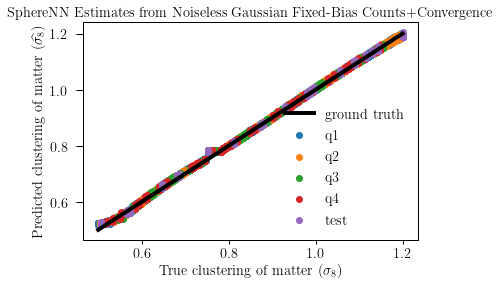

In [21]:
plot_preds_vs_truths(results, "SphereNN Estimates from Noiseless Gaussian Fixed-Bias Counts+Convergence")

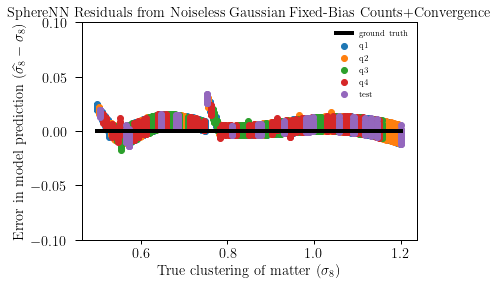

In [22]:
plot_residuals(results, "SphereNN Residuals from Noiseless Gaussian Fixed-Bias Counts+Convergence")

In [23]:
print_losses(results)

In [24]:
serialize_predictions(results)

In [25]:
model = build_model()

In [59]:
keras.utils.plot_model(model, to_file="../figures/spherenn-simple-model-graph.png")

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [60]:
model = build_model()
model.load_weights(checkpoint_path+"-Q4")

In [58]:
model.save("../figures/spherenn_model.h5")

In [63]:
keras.utils.plot_model(model, to_file="../figures/spherenn-simple-model-graph.png")

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
